(1) 데이터 간단 설명: 

전체 126개의 컬럼(기본 정보, 활동량, 특정 질병 의사진단 여부 등등에 대한 설문값)

target 변수: fat

fat은 정상, 비만, 과체중에 대한 구분값으로 각각 0,1,2의 값이 매겨져있음

구분 기준은 남/여 체지방률이며

###### 남자 

###### 정상: 16.7~22.5

###### 과체중: 22.5~24.8

###### 비만: 24.8~

###### --------------------------------------------------------------------------
###### 여자 

###### 정상: 28.0~34.3

###### 과체중: 34.3~36.49

###### 비만:36.5~

###### --------------------------------------------------------------------------
현재 데이터는 정상, 비만, 과체중 레코드를 전부 같은 개수만큼 샘플링한 데이터이다. (결측치 x)

-----

(2) 특성 필터링 : 126개의 컬럼중 변별력없는 컬럼을 제거하기 위해 진행

"seaborn에서 나온 그래프 중 x값(각 컬럼의 설문 값)별로 생기는 target label값의 비율이 비슷한 컬럼을 걸러내기 위한 알고리즘 작성"

과정:

1.연속형 컬럼 제외

2.카테고리형 컬럼에 알고리즘 적용 -> 특성 필터링
(특정 값이 비어있는 등의 예외적인 컬럼들은 따로 모아서 추가 분석 진행함)

In [1]:
import pandas as pd
import numpy as np

data=pd.read_csv(r"C:\Users\USER\Desktop\건우\fat_predict_project\data\public_health_data_csv\profiling용.csv")

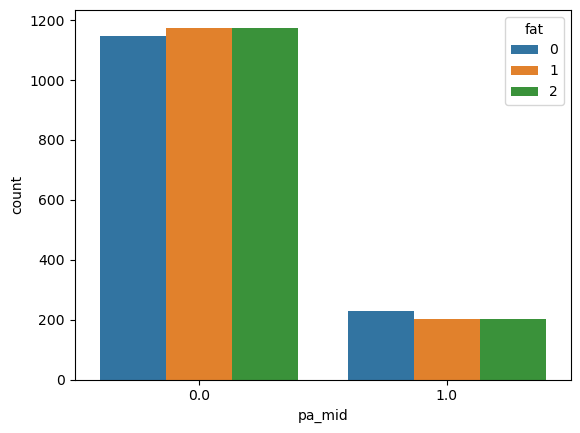

In [2]:
# 변별력 없는 컬럼 예시
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='pa_mid', hue='fat', data=data)
plt.legend(loc='upper right', title='fat')
plt.show()

In [3]:
# 걸러낼 col을 모을 최종 list
total_filtered_list=[]

---------
1. 연속형 컬럼 검사

###### 각 특성마다의 고유한 값 개수로 연속형 컬럼 구분 기준 확인

In [4]:
feature_multi_values={}
for col in data.columns:
    unique_values=data[col].unique()
    feature_multi_values[col]=len(unique_values)

multi_values=dict(sorted(feature_multi_values.items(), key=lambda x:x[1]))

# print(sorted(set(multi_values.values())))

multi_values_list=[]
for key, value in multi_values.items():
    if value>=14:
        print(key, ": ",value)
        multi_values_list.append(key) #연속형 컬럼이름 추가

BP8 :  14
EC_lgw_2 :  16
EC_ind :  18
EC_wht_3 :  50
age :  62
EC_wht_2 :  94
HE_ht :  447
HE_wc :  496
HE_wt :  576
N_INTK :  4128
N_EN :  4128
N_WATER :  4128
N_PROT :  4128
N_FAT :  4128
N_CHO :  4128
DW_WBT_BMD :  4131
DW_WBT_pFT :  4131



###### BP8: 하루 평균 수면시간 00시간 (1~24), 99 모름

###### EC_wht_2: 전일제 근로시간 000시간 , 888비해당, 999모름

###### EC_wht_3: 시간제 근로시간 000시간 , 888비해당, 999모름

=> 연속형이지만 값의 수가 많지 않음 -> profiling


###### EC_lgw_2 :  16

###### EC_ind :  18

=> 두가지는 일자리 분류 코드(생산직, 사무직...)인데 값의 종류가 많은 것

나머지는 연속형 변수

###### 'HE_wc' : 허리둘레

###### 'N_WATER' : 수분섭취량 

###### 'N_CHO' : 탄수화물

###### 'HE_ht':신장

###### 'N_FAT': 지방섭취량

###### 'DW_WBT_pFT' : 체지방률

###### 'DW_WBT_BMD' : 총 골밀도

###### 'age' : 나이

###### 'HE_wt' : 체중

###### 'N_INTK' : 식품섭취량

###### 'N_EN' : 에너지 섭취량

###### 'N_PROT' : 단백질 섭취량

값의 수가 많지 않은 BP8,EC_wht_2,EC_wht_3을 버릴지 판단하기 위해 profiling

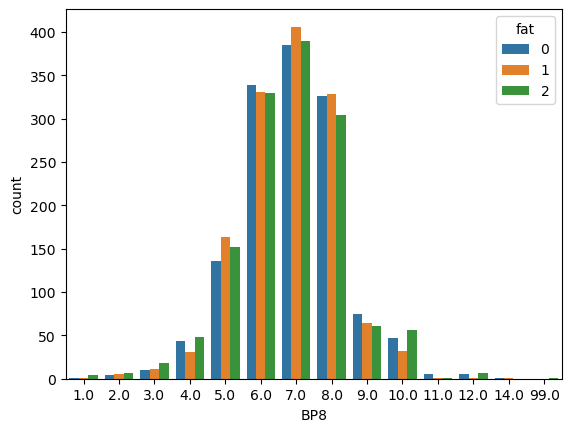

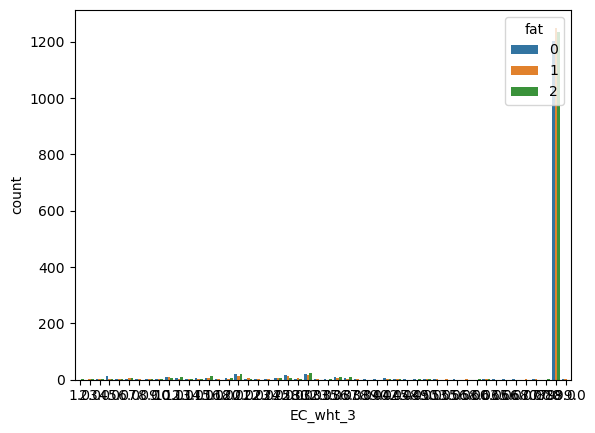

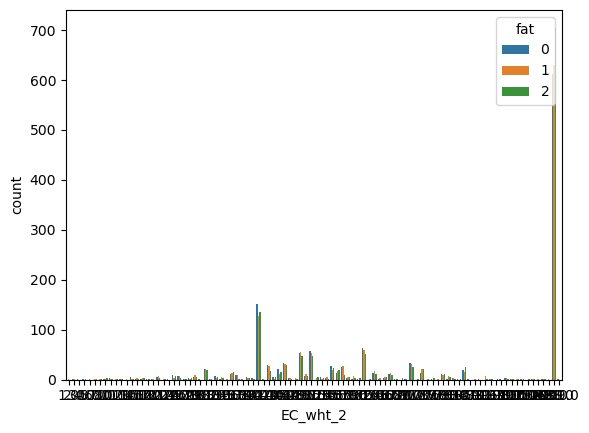

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

profile=['BP8','EC_wht_3','EC_wht_2']

for i in range(len(profile)):
    sns.countplot(x=profile[i], hue='fat', data=data)
    plt.legend(loc='upper right', title='fat')
    plt.show()

'EC_wht_3', 'EC_wht_2'는 888 비해당이 대다수 이므로 제거  (일자리 분류 코드)

In [6]:
#최종 걸러낼 리스트에 추가
total_filtered_list.append(['EC_wht_3', 'EC_wht_2'])

In [7]:
#데이터셋에서도 제거
data=data.drop(['EC_wht_3', 'EC_wht_2'], axis=1)

최종 연속형 컬럼 리스트 (continuous_columns)

In [8]:
countinuous_columns=set(multi_values_list)-{'EC_wht_3', 'EC_wht_2', 'EC_lgw_2','EC_ind'}
countinuous_columns=list(countinuous_columns)
print(countinuous_columns)

['N_INTK', 'DW_WBT_pFT', 'BP8', 'HE_wc', 'N_WATER', 'N_PROT', 'DW_WBT_BMD', 'HE_ht', 'HE_wt', 'N_CHO', 'age', 'N_EN', 'N_FAT']


-----
2. 각 특성마다의 설문 값에 따라 달라지는 fat(정상, 과체중, 비만)의 비율 확인 후 필터링

과정

2.1 fat 값에 따라 데이터프레임을 3개로 나누었을 때 값 종류의 개수가 다른것이 존재하는 예외적인 요소는 따로 모아서 profiling

2.2 예외적인 컬럼을 제외한 나머지 컬럼(81개)에 mse기반 필터링 알고리즘 적용

2.3 그 후 예외적인 컬럼들에는 추가 분석 및 값 조정 후 알고리즘 적용

--------
2.1 fat 값에 따라 데이터프레임을 3개로 나누었을 때 값 종류의 개수가 다른것이 존재하는 예외적인 요소는 따로 모아서 추가 분석

###### (밑이 그 예시)

=> fat 값에 따라 값 종류의 개수가 다른 특성 조사 (diff라는 리스트에 저장)

In [9]:
# 연속형 column을 제외한 데이터 프레임 생성
ratio_data=data.drop(countinuous_columns, axis=1)

fat값이 0인 레코드만 모은 데이터 프레임 값 비율


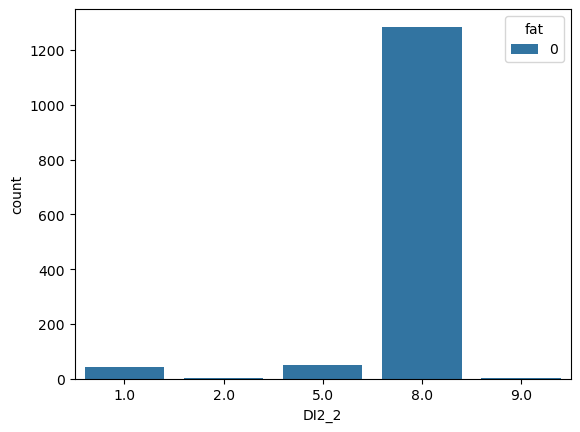

fat값이 1인 레코드만 모은 데이터 프레임 값 비율


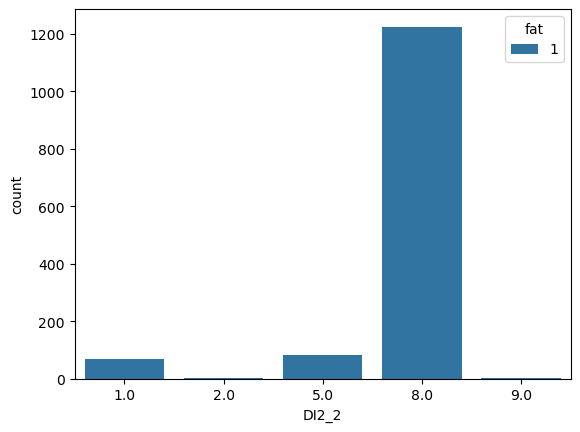

fat값이 2인 레코드만 모은 데이터 프레임 값 비율


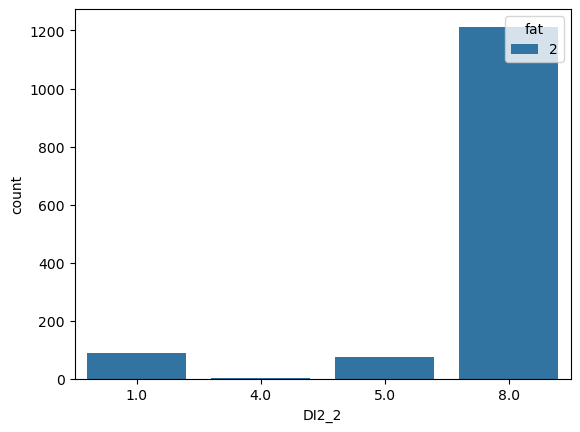

In [10]:
fat_values = sorted(ratio_data['fat'].unique())

i=0
while i <3:
    fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]
    sns.countplot(x='DI2_2', hue='fat', data=fat_data)
    plt.legend(loc="upper right", title="fat")
    print(f"fat값이 {fat_values[i]}인 레코드만 모은 데이터 프레임 값 비율")
    plt.show()
    i+=1

In [11]:
diff = []

for col in ratio_data.columns:
    values_list = []
    i = 0
    while i < 3:    # fat값 0, 1, 2에 따라 반복
        fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]  # fat 값이 0인 레코드로만 만든 데이터프레임, 1로 만든, 2로 만든
        values_list.append(fat_data[col].unique())  # 해당 열(col)에서 고유한 값들을 가져와서 values_list에 추가
        i+=1
    if ( (len(values_list[0]) != len(values_list[1])) or (len(values_list[0]) != len(values_list[2])) or (len(values_list[1]) != len(values_list[2]))):
        diff.append(col)

print("fat 값에 따라 값 종류의 개수가 다른 특성")
print(diff)

fat 값에 따라 값 종류의 개수가 다른 특성
['genertn', 'D_1_1', 'DI2_2', 'DI3_dg', 'DJ5_dg', 'DC2_dg', 'DC6_dg', 'DK8_dg', 'LQ4_00', 'EC_lgw_2', 'EC_pjob_4', 'BO1_1', 'BO1_3', 'BD1_11', 'BD2_1', 'BP1', 'L_SNA_FQ', 'L_OUT_FQ', 'L_BR_FAM', 'L_LN_FAM', 'L_DN_FAM', 'LK_GD', 'LK_GD_P1', 'LK_GD_P2', 'LK_GD_P3', 'LK_GD_P4', 'LK_GD_P5', 'LK_GD_P6', 'LK_LAB', 'N_DIET']


-----
2.2 예외적인 컬럼을 제외한 나머지 컬럼(81개)에 mse기반 필터링 알고리즘 적용

In [12]:
ratio_data=ratio_data.drop(diff, axis=1)

In [13]:
fat_values = sorted(ratio_data['fat'].unique())
for col in ratio_data.columns:
    value_list = [] # 딕셔너리를 추가할 리스트
    value_list_2 = [] #딕셔너리의 value들의 전체값 대비 비율을 리스트로 만들어서 추가할 리스트
    i = 0
    
    print(col) #현재 column
    while i < 3:    #fat값 0,1,2에 따라 반복
        fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]       #fat값이 0인 레코드로만 만든 데이터프레임, 1로만든, 2로만든
        origin_dict=fat_data[col].value_counts().to_dict()       #value_list에 각 값 종류와 개수가 맵핑된 딕셔너리로 추가
        value_list.append(dict(sorted(origin_dict.items())))
        i += 1 
    print(value_list)
    
    for i in range(len(value_list)):
        total_value = sum(value_list[i].values())   #value_list의 i번째 리스트의 값 총합
        new_dict = {key: round((value / total_value), 2) for key, value in value_list[i].items()}   #키에 i번째 리스트의 각 값을 총합으로 나눈 평균값을 매핑시킴 (소수점 둘째자리)
        value_list_2.append(new_dict)       # value_list_2에는 각 리스트의 요소가 전체 값 기준 비율로 저장됨
    
    print("비율")
    total_list = [list(d.values()) for d in value_list_2]   # value_list_2에 저장된 딕셔너리들의 value들을 리스트화시킴
    print(total_list)
    
    #각 리스트별 같은 위치의 요소의 평균구하기 -> 하나의 리스트의 총 요소개수만큼의 평균이 나와야함
    # 예를 들어 설문 값이 1,2,3,4 -> 총 4개의 평균값 필요 (fat1일때의 1이라고 설문한 비율의 평균)
    
    #total_list에는 총 3개의 리스트가 저장되어있음
    # for문으로 1번째 리스트에서 0번째 값+2번째 리스트의 0번째 값 + 3번째 리스트의 0번째 값
    # => 값 종류의 개수만큼 while문, 그안에서 for문으로 각 리스트의 i번째 값 가져와서 합치고 총 개수로 나누기
    list_elem_length=len(total_list[0])         # 값의 종류의 개수가 동일한것만 남겼기 때문에 가능함
    k=0
    avg_list=[]    #평균값 넣을 리스트
    while(k<list_elem_length):  # 만약 값 개수가 5개라고 가정하면 총 5번 반복 (요소 인덱스)
        i_elem=0
        for i in range(3):     #total_list의 각 리스트(fat 0, 1, 2)를 순회하는 인덱스
            i_elem +=total_list[i][k]
        avg_list.append(round(i_elem/3,2))
        k+=1
    print("평균값")
    print(avg_list)

sex
[{1: 502, 2: 875}, {1: 610, 2: 767}, {1: 628, 2: 749}]
비율
[[0.36, 0.64], [0.44, 0.56], [0.46, 0.54]]
평균값
[0.42, 0.58]
incm5
[{1.0: 273, 2.0: 285, 3.0: 289, 4.0: 290, 5.0: 240}, {1.0: 227, 2.0: 282, 3.0: 282, 4.0: 294, 5.0: 292}, {1.0: 255, 2.0: 270, 3.0: 286, 4.0: 272, 5.0: 294}]
비율
[[0.2, 0.21, 0.21, 0.21, 0.17], [0.16, 0.2, 0.2, 0.21, 0.21], [0.19, 0.2, 0.21, 0.2, 0.21]]
평균값
[0.18, 0.2, 0.21, 0.21, 0.2]
ho_incm5
[{1.0: 310, 2.0: 291, 3.0: 266, 4.0: 242, 5.0: 268}, {1.0: 307, 2.0: 286, 3.0: 256, 4.0: 240, 5.0: 288}, {1.0: 343, 2.0: 279, 3.0: 263, 4.0: 231, 5.0: 261}]
비율
[[0.23, 0.21, 0.19, 0.18, 0.19], [0.22, 0.21, 0.19, 0.17, 0.21], [0.25, 0.2, 0.19, 0.17, 0.19]]
평균값
[0.23, 0.21, 0.19, 0.17, 0.2]
edu
[{1.0: 365, 2.0: 157, 3.0: 477, 4.0: 378}, {1.0: 428, 2.0: 170, 3.0: 442, 4.0: 337}, {1.0: 467, 2.0: 168, 3.0: 445, 4.0: 297}]
비율
[[0.27, 0.11, 0.35, 0.27], [0.31, 0.12, 0.32, 0.24], [0.34, 0.12, 0.32, 0.22]]
평균값
[0.31, 0.12, 0.33, 0.24]
occp
[{1.0: 155, 2.0: 100, 3.0: 163, 4.0: 167,

평균 값 리스트와 각 리스트의 유사도를 mse로 측정해봄

In [14]:
def mse(avg_list, total_list):
    mse_list=[]
    for i in range(len(avg_list)):     # i : 요소 인덱스 "요소개수만큼 mse 계산 ex) 설문값이 5개면 mse도 5개 (fat값에 따라 3개의 값이 있을때 이 3개의 값을 평균값과 비교)""
        mse = sum((avg_list[i] - total_list[j][i]) ** 2 for j in range(len(total_list))) / len(total_list)    # j : 리스트 인덱스 "fat개수만큼 (= total list안의 리스트개수)"
        mse_list.append(mse)
    return mse_list

In [15]:
import statistics
# 걸러낼col의 이름을 추가할 리스트

def mse_col_filter(ratio_data, threshold):
    un_col=[]
    
    fat_values = sorted(ratio_data['fat'].unique())
    for col in ratio_data.columns:
        value_list = [] # 딕셔너리를 추가할 리스트
        value_list_2 = [] #딕셔너리의 value들의 전체값 대비 비율을 리스트로 만들어서 추가할 리스트
        i = 0
        
        # print(col) #현재 column
        while i < 3:    #fat값 0,1,2에 따라 반복
            fat_data = ratio_data[ratio_data['fat'] == fat_values[i]]       #fat값이 0인 레코드로만 만든 데이터프레임, 1로만든, 2로만든
            origin_dict=fat_data[col].value_counts().to_dict()       #value_list에 각 값 종류와 개수가 맵핑된 딕셔너리로 추가
            value_list.append(dict(sorted(origin_dict.items())))
            i += 1 
        # print(value_list)
        
        for i in range(len(value_list)):
            total_value = sum(value_list[i].values())   #value_list의 i번째 리스트의 값 총합
            new_dict = {key: round((value / total_value), 2) for key, value in value_list[i].items()}   #키에 i번째 리스트의 각 값을 총합으로 나눈 평균값을 매핑시킴 (소수점 둘째자리)
            value_list_2.append(new_dict)       # value_list_2에는 각 리스트의 요소가 전체 값 기준 비율로 저장됨
        
        # print("비율")
        total_list = [list(d.values()) for d in value_list_2]   # value_list_2에 저장된 딕셔너리들의 value들을 리스트화시킴
        # print(total_list)
        
        #각 리스트별 같은 위치의 요소의 평균구하기 -> 하나의 리스트의 총 요소개수만큼의 평균이 나와야함
        # 예를 들어 설문 값이 1,2,3,4 -> 총 4개의 평균값 필요 (fat1일때의 1이라고 설문한 비율의 평균)
        
        #total_list에는 총 3개의 리스트가 저장되어있음
        # for문으로 1번째 리스트에서 0번째 값+2번째 리스트의 0번째 값 + 3번째 리스트의 0번째 값
        # => 값 종류의 개수만큼 while문, 그안에서 for문으로 각 리스트의 i번째 값 가져와서 합치고 총 개수로 나누기
        list_elem_length=len(total_list[0])         # 값의 종류의 개수가 동일한것만 남겼기 때문에 가능함
        k=0
        avg_list=[]    #평균값 넣을 리스트
        while(k<list_elem_length):  # 만약 값 개수가 5개라고 가정하면 총 5번 반복 (요소 인덱스)
            i_elem=0
            for i in range(3):     #total_list의 각 리스트(fat 0, 1, 2)를 순회하는 인덱스
                i_elem +=total_list[i][k]
            avg_list.append(round(i_elem/3,2))
            k+=1
        # print("평균값")
        # print(avg_list)
        mse_list=mse(avg_list,total_list)
        # print("mse 값")
        # print(mse_list)
        # print("mse 평균값")
        # print(statistics.mean(mse_list))
        
        # 임의의 mse 평균값 이하의 column을 un_col리스트에 추가
        if(statistics.mean(mse_list)<threshold):
            un_col.append(col)
        

    # 최종적으로 걸러낼 col 리스트
    # print("---"*100)
    # print("임계값 이하의 컬럼들")
    # print(un_col)
    print("전체 개수: ", len(ratio_data.columns))
    print("걸러진 개수: ", len(un_col))
    return(un_col) # 걸러낼 리스트 반환

In [16]:
filterd_list=mse_col_filter(ratio_data, 0.001)
total_filtered_list.append(filterd_list) # data에서 걸러낼 컬럼의 최종 리스트에 추가

전체 개수:  81
걸러진 개수:  68


81개 중 68개를 걸러낼 정도로 임계값(0.001) 설정-> 필터링

-----
2.3 위에서 값의 비율이 없어서 따로 빼두었던 예외적인 컬럼들 값 조정 및 알고리즘 적용


In [17]:
diff_data=data[diff +['fat']]

In [18]:
profile=diff

genertn


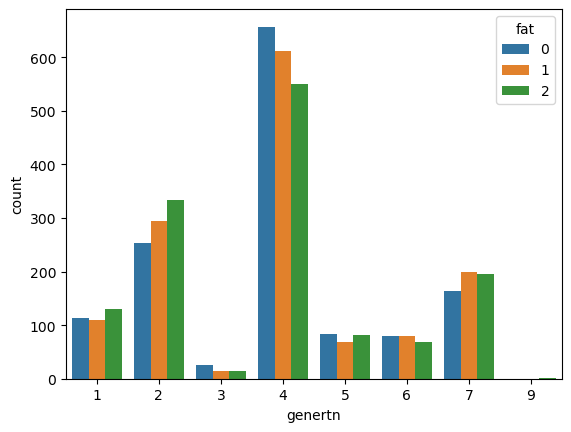

D_1_1


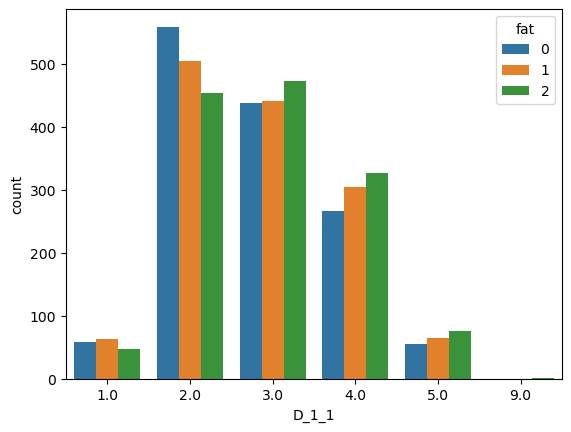

DI2_2


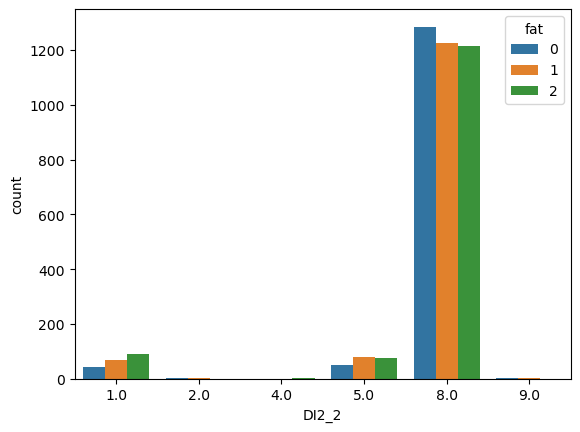

DI3_dg


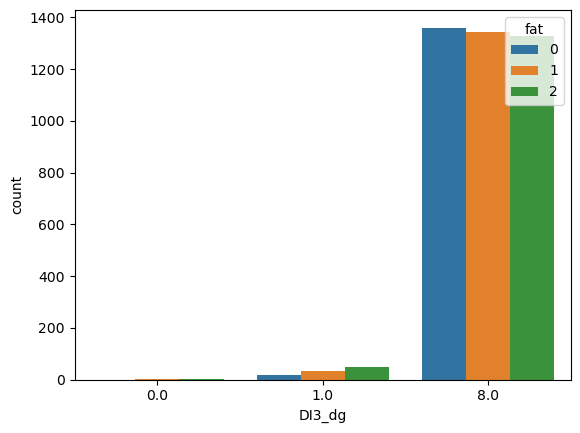

DJ5_dg


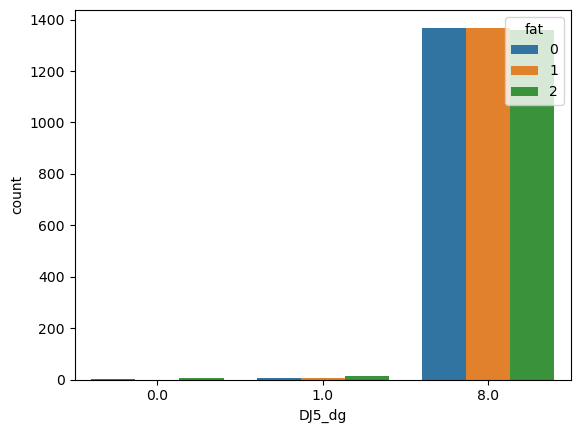

DC2_dg


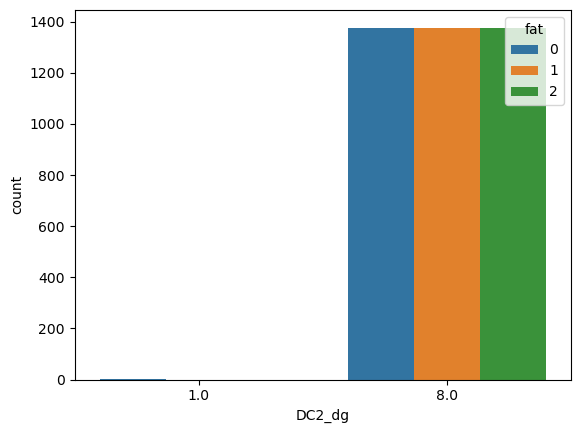

DC6_dg


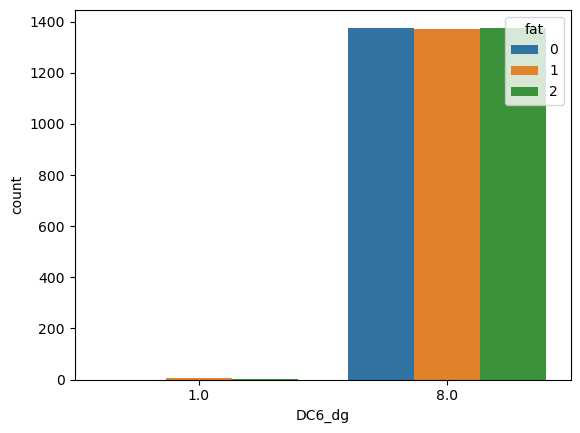

DK8_dg


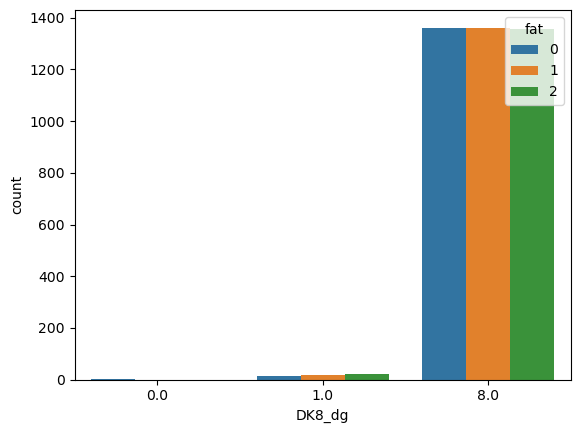

LQ4_00


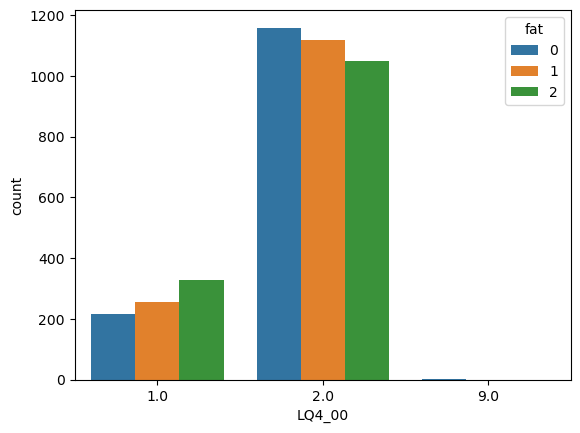

EC_lgw_2


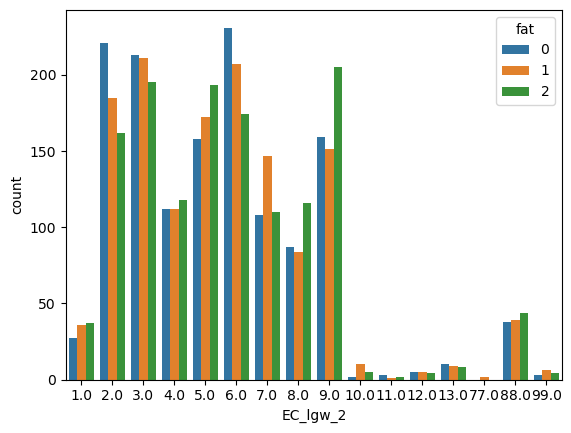

EC_pjob_4


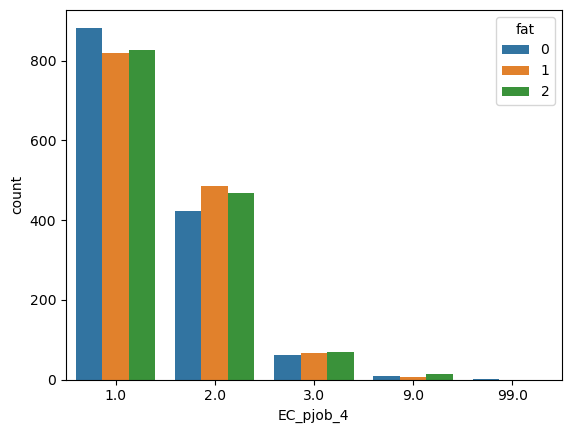

BO1_1


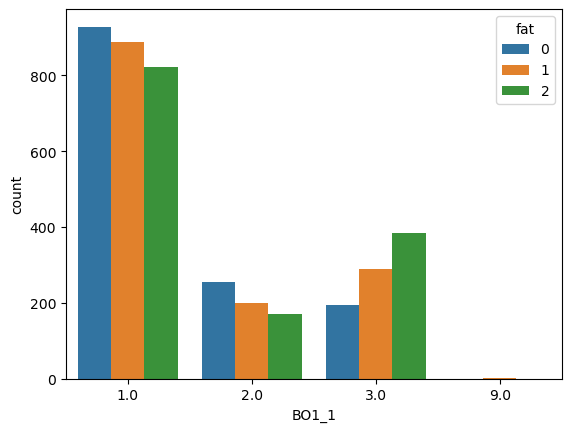

BO1_3


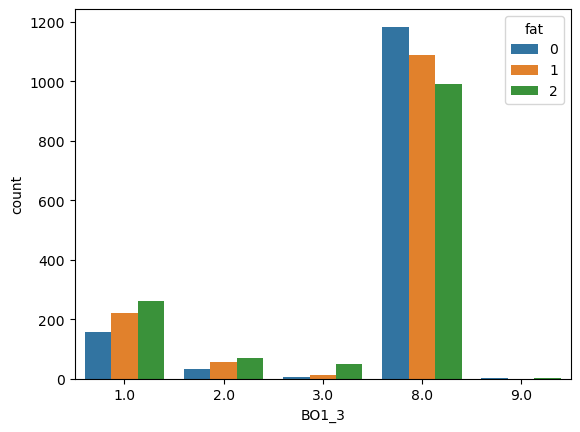

BD1_11


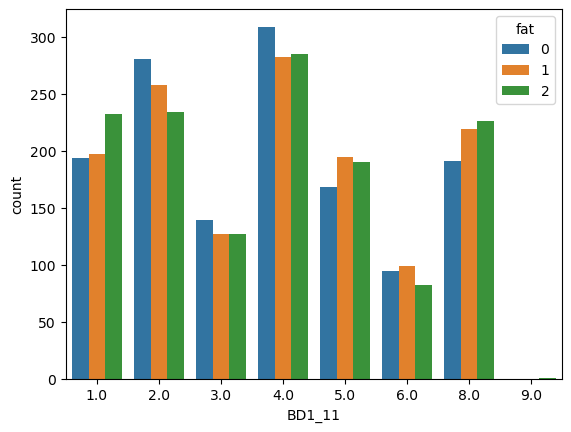

BD2_1


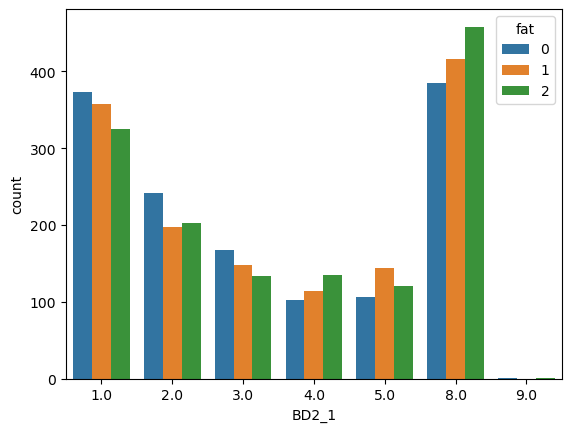

BP1


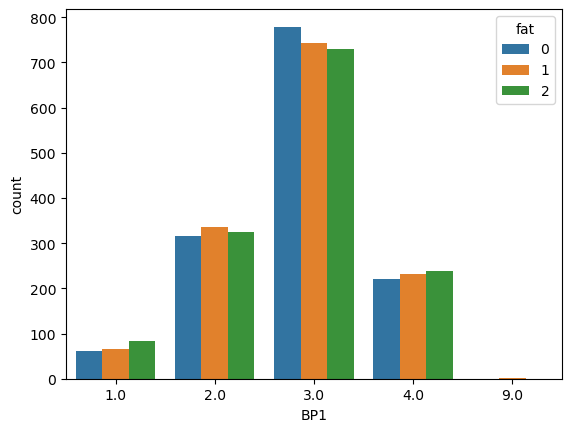

L_SNA_FQ


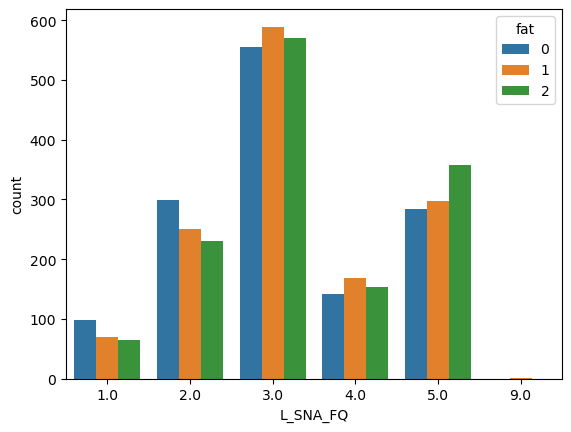

L_OUT_FQ


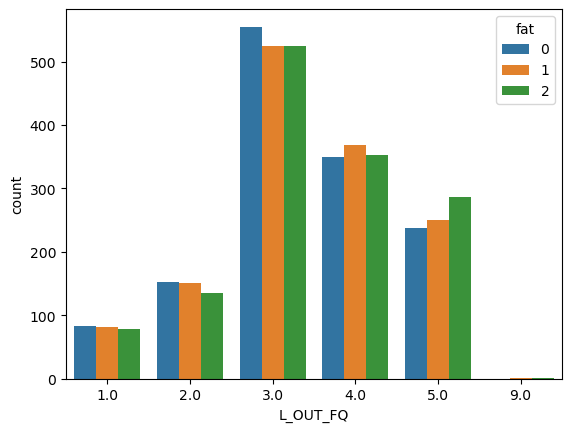

L_BR_FAM


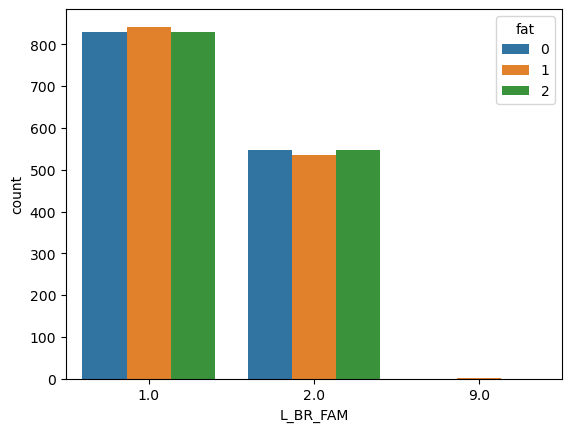

L_LN_FAM


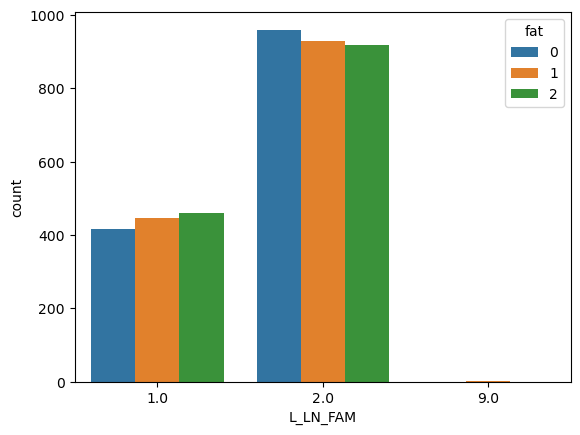

L_DN_FAM


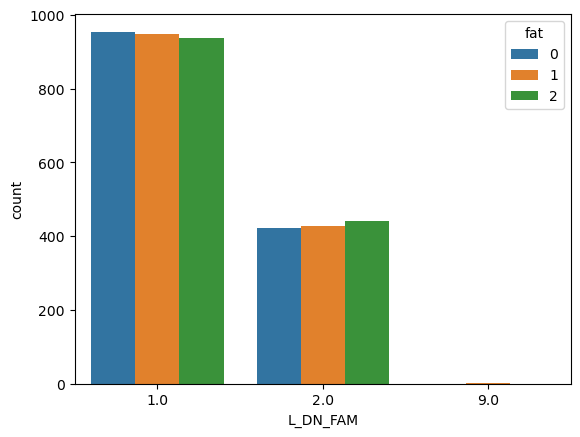

LK_GD


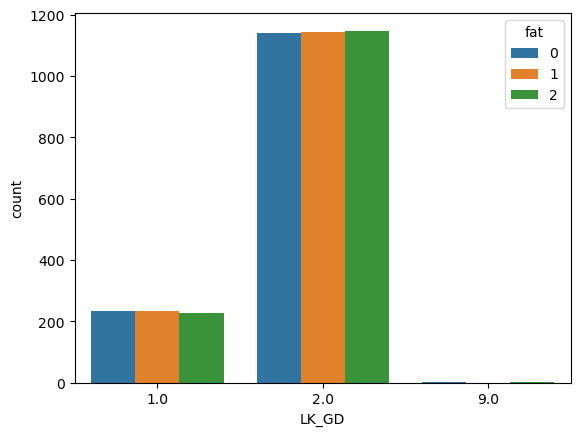

LK_GD_P1


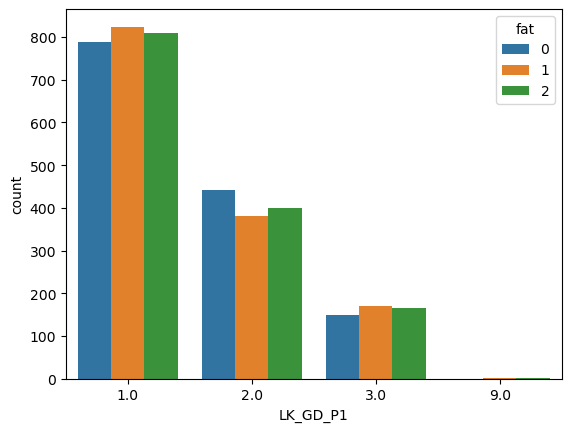

LK_GD_P2


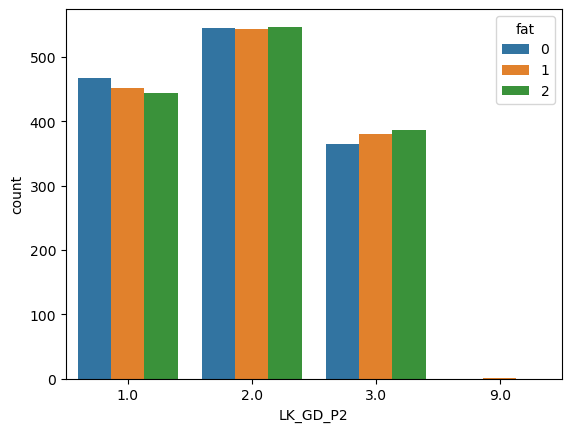

LK_GD_P3


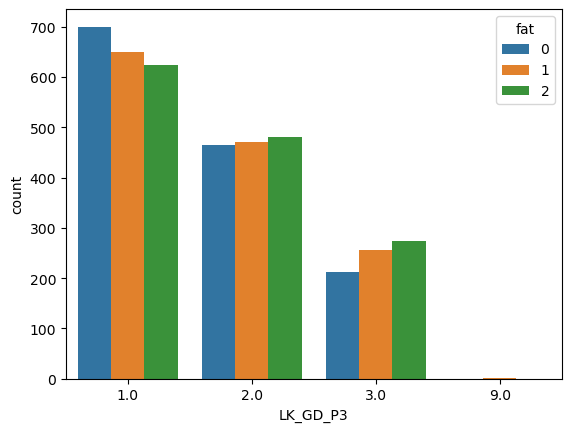

LK_GD_P4


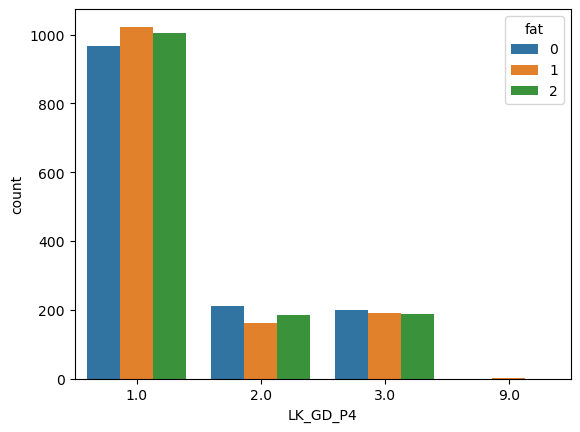

LK_GD_P5


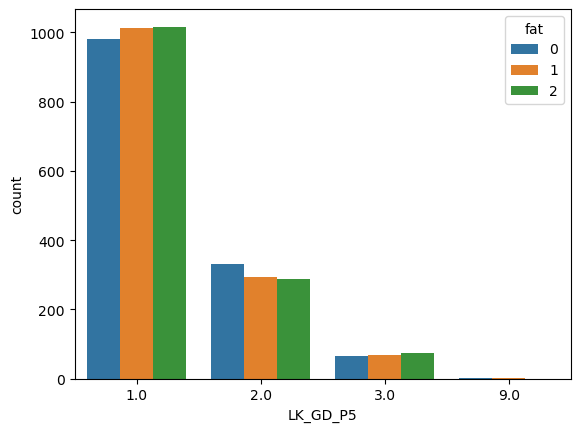

LK_GD_P6


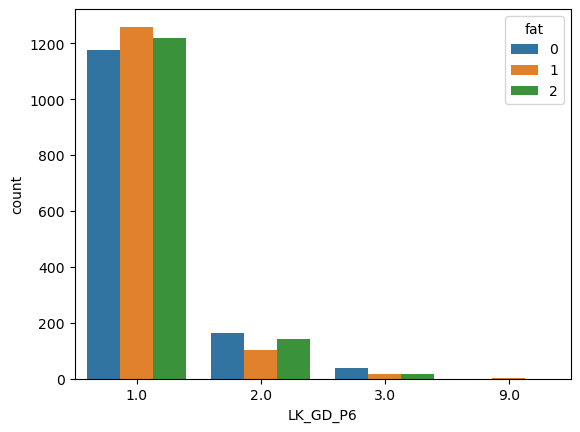

LK_LAB


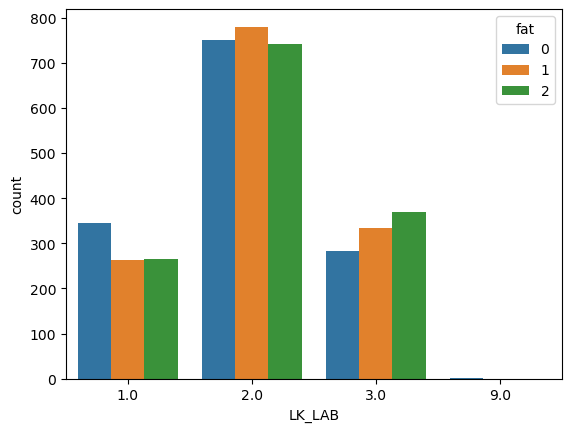

N_DIET


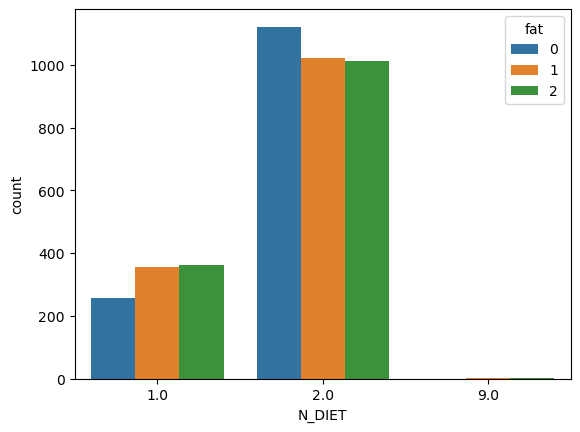

In [19]:
for i in range(len(profile)):
    sns.countplot(x=profile[i], hue='fat', data=diff_data)
    plt.legend(loc='upper right', title='fat')
    print(profile[i])
    plt.show()

###### 'DI3_dg', 'DJ5_dg', 'DC2_dg', 'DC6_dg', 'DK8_dg'

=> DROP (0,1이 거의 없고 9에 대다수몰려있음) : 모름이 대다수임

In [20]:
drop_list=['DI3_dg', 'DJ5_dg', 'DC2_dg', 'DC6_dg', 'DK8_dg', 'DI2_2']
diff_data=diff_data.drop(drop_list, axis=1)

total_filtered_list.append(drop_list)

###### D_1_1 : 의미있는 비율로 판단, 9(모름)에 해당하는 레코드를 제거(거의 없음)

###### genertn: 의미있는 비율로 판단, 9에 해당하는 레코드를 제거(거의 없음)

###### LQ4_00 : 9 레코드 제거

###### EC_lgw_2 : 의미있는 비율로 판단, 77에 해당하는 레코드 제거

###### EC_pjob_4: 의미있는 비율로 판단, 99,9에 해당하는 레코드 제거

###### BO1_1 : 9레코드 제거

###### BO1_3: 9레코드 제거

###### BD1_11 :9레코드 제거

###### BD2_1:9레코드 제거

###### BP1:9레코드 제거...

###### 대부분 9가 없음

=> 9,99,77에 해당하는 레코드 제거 후 필터링 알고리즘 적용

In [21]:
rows_with_9 = diff_data[diff_data.eq(9).any(axis=1)]
diff_data=diff_data[~diff_data.eq(9).any(axis=1)]

rows_with_99= diff_data[diff_data.eq(99).any(axis=1)]
diff_data=diff_data[~diff_data.eq(99).any(axis=1)]

rows_with_77=diff_data[diff_data.eq(77).any(axis=1)]
diff_data=diff_data[~diff_data.eq(77).any(axis=1)]

-----


남은 컬럼들 다시 유사도 조사

In [22]:
filterd_list=mse_col_filter(diff_data, 0.001)

전체 개수:  25
걸러진 개수:  22


In [23]:
total_filtered_list.append(filterd_list)

같은 임계값(0.001)으로 걸렀을 때 22개 걸러짐

----
결론적으로 남은 컬럼들 조사

In [25]:
data=pd.read_csv(r"C:\Users\USER\Desktop\건우\fat_predict_project\data\public_health_data_csv\profiling용.csv")

In [26]:
# 걸러낼 컬럼
total_unpacked_list=[]
for i in total_filtered_list:
    for j in range(len(i)):
        total_unpacked_list.append(i[j])

set_fet={'fat'}
set_total=set(total_unpacked_list)-set_fet
total_unpacked_list=list(set_total)

In [27]:
data=data.drop(total_unpacked_list, axis=1)

In [28]:
print(len(data.columns))

30


최종적으로 총 30개의 컬럼만 남김

---------
----------
모델링


1.연속형 컬럼에 대해 이상치 탐지

In [29]:
continuous_data=data[countinuous_columns]

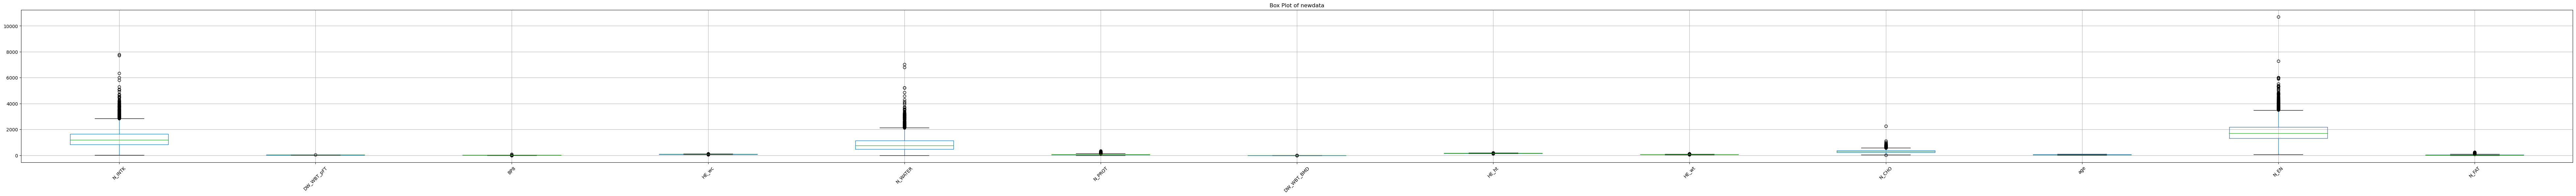

In [30]:
import matplotlib.pyplot as plt

# 이상치 확인을 위한 상자 그림(Box Plot)
plt.figure(figsize=(100 ,6))  # 그래프의 크기 설정
pd.DataFrame(continuous_data).boxplot()  # 각 열에 대한 상자 그림 생성
plt.xticks(rotation=45)  # x축 레이블 회전
plt.title('Box Plot of newdata')  # 그래프 제목 설정
plt.show()  # 그래프 출력

In [31]:
import numpy as np

# 선택한 특성들만 추출
selected_features = ['N_EN', 'N_WATER', 'N_INTK']
data_selected = data[selected_features]

# Z-점수 계산
z_scores = np.abs((data_selected- data_selected.mean()) / data_selected.std())

# 이상치로 판단할 임계값 설정 
threshold = 3

# 이상치 탐지
outliers = np.where(np.any(z_scores > threshold, axis=1))

# 이상치가 있는 행의 인덱스 출력 (겹치는 행은 중복 제거)
outlier_rows = np.unique(outliers[0])
print("Rows with outliers:", len(outlier_rows))

# 이상치가 있는 행들을 전체 데이터프레임에서 삭제
data=data.drop(outlier_rows)

Rows with outliers: 107


-------
2.이상치 탐지 및 제거 마치고 연속형 변수, 목표변수('fat') 분리 후에 남은 카테고리형 변수들 원핫인코딩

In [32]:
#원핫인코딩을 위해서 연속형 변수, 목표 변수 분리
one_hot_encoded=data.drop(countinuous_columns, axis=1)
one_hot_encoded=one_hot_encoded.drop('fat', axis=1)

print(one_hot_encoded.columns)

Index(['sex', 'DI1_dg', 'DI1_2', 'EC1_1', 'BO1_1', 'BO1_3', 'BO2_1', 'BO3_01',
       'BO3_02', 'BO3_03', 'BO3_05', 'BO3_04', 'BO3_12', 'BO3_07', 'BO3_09',
       'N_DIET'],
      dtype='object')


###### 변수 설명은 메모장에 정리했습니다!


In [33]:
#정수값 카테고리형으로 변환 후 원 핫 인코딩
one_hot_encoded=one_hot_encoded.astype('category')

encoded_data=pd.get_dummies(one_hot_encoded)

----
3.원핫인코딩 후 연속형 컬럼, 목표변수('fat')과 병합

In [34]:
data=pd.concat([encoded_data,data[countinuous_columns],data['fat']], axis=1)

연속형 값 정규화(min_max_scaling)

In [35]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 선택할 컬럼 리스트
columns_to_scale = countinuous_columns

# 선택한 컬럼들에 Min-Max Scaling 적용
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

모델링 (랜덤포레스트)

In [36]:
y = data['fat']
X = data.drop(['fat', 'DW_WBT_pFT','DW_WBT_BMD', 'BO1_1_2.0',
       'BO1_1_3.0', 'BO3_03_1.0', 'BO1_3_8.0', 'BO1_3_1.0', 'BO3_03_0.0',
       'DI1_2_1.0', 'DI1_dg_8.0', 'BO3_01_0.0', 'DI1_2_8.0', 'DI1_dg_1.0',
       'BO3_01_1.0', 'BO2_1_2.0', 'BO2_1_3.0', 'BO3_07_0.0', 'BO2_1_4.0',
       'BO1_3_2.0', 'BO1_3_3.0', 'BO3_07_1.0', 'BO3_12_0.0', 'BO3_04_0.0',
       'DI1_2_5.0', 'BO3_04_8.0', 'BO3_02_0.0', 'BO3_09_0.0', 'BO3_05_0.0',
       'BO3_12_1.0', 'BO3_12_8.0', 'BO3_01_8.0', 'BO3_02_8.0', 'BO3_07_8.0',
       'BO3_09_8.0', 'BO3_04_1.0', 'BO3_03_8.0', 'BO3_05_1.0', 'BO3_02_1.0',
       'BO3_09_1.0', 'BO3_05_8.0', 'DI1_2_2.0', 'DI1_2_9.0', 'DI1_dg_0.0',
       'BO1_3_9.0', 'BO1_1_9.0', 'DI1_2_4.0', 'DI1_2_3.0', 'N_DIET_9.0'  # feature importance로 잘라봄
               
            ], axis=1)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

Accuracy: 0.5447019867549668
F1 스코어: 0.5416373395487598
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       404
           1       0.43      0.39      0.40       400
           2       0.57      0.60      0.58       404

    accuracy                           0.54      1208
   macro avg       0.54      0.54      0.54      1208
weighted avg       0.54      0.54      0.54      1208

Index(['HE_wc', 'HE_wt', 'HE_ht', 'N_PROT', 'N_FAT', 'N_CHO', 'N_EN',
       'N_WATER', 'age', 'N_INTK', 'BP8', 'BO2_1_1.0', 'BO1_1_1.0',
       'EC1_1_2.0', 'EC1_1_1.0', 'N_DIET_1.0', 'N_DIET_2.0', 'sex_1', 'sex_2'],
      dtype='object')


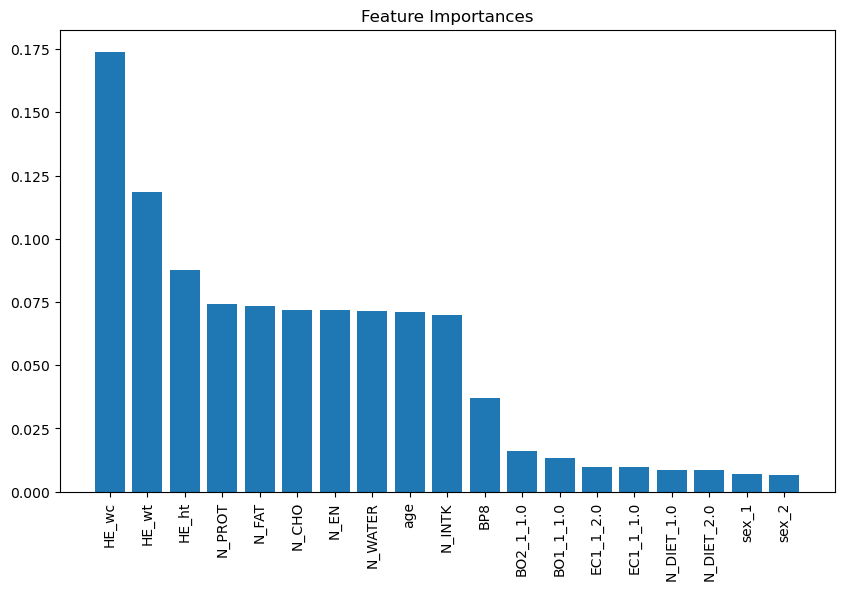

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

# 모델 객체
rf_classifier = RandomForestClassifier()

# 모델 훈련
rf_classifier.fit(X_train, y_train)

# 예측값
y_pred = rf_classifier.predict(X_test)

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# f1 스코어
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 스코어:", f1)

report = classification_report(y_test, y_pred)
print(report)

# feature importances
importances = rf_classifier.feature_importances_

# 특성 이름
feature_names = X.columns

# 중요도 큰거부터 나오도록 순서 반대로
indices = np.argsort(importances)[::-1]
print(feature_names[indices])

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.show()

자체 피드백:

###### 1. 위에 선택된 컬럼들을 profiling했을 때, 비해당에 해당하는 값들을 아니오로 바꾸면 예에 해당하는 값이 거의 없음 
###### -> 비해당 값을 아니오로 매핑하는 것보다 컬럼 삭제가 맞는 것 같음.
###### 하지만 컬럼을 없애도 성능은 그대로...

###### 2. 데이터셋 샘플링을 각 범위(정상, 비만 ,과체중)에서 같은 개수만큼 뽑은게 문제일 수도 있수도 있으나,
###### 샘플링 없이 비율을 맞추지 않고 진행했을 때 전체 accuracy는 증가하나, 과체중에 대한 precision, recall이 거의 없어짐

###### => 과체중 예측 범위가 정상, 비만에 비해 좁은 영향이 매우 큰 것 같음
###### 정상: ~22.5
###### 과체중:22.5~24.8 (약 2% 범위)
###### 비만: 22.8~



###### 3. 정상, 비만을 예측하는 모델과 정상, 과체중을 예측하는 모델, 과체중, 비만을 예측하는 모델 3가지를 만들어서 앙상블해보는 것은 어떨지 고민중입니다 
###### (다중 클래스(3가지) 예측을 이진 클래스 예측 모델 3개로 분할해서 예측) 
###### 예를 들어 1번 모델에서 정상-> 정상
###### 	2번 모델에서 과체중, 3번모델에서 과체중-> 과체중
###### 	3번 모델, 2번 모델에서 비만 -> 비만
###### 	2번 모델 과체중, 3번 모델 비만-> 1번 모델이 비만이면 비만, 아니면 과체중..?

###### 4. 데이터셋 자체가 너무 별로인 것 일 수도 있음

###### 5. 연속형 값은 카테고리형으로 구간화해서 넣는 것도 의미있을것 같지만 가장 큰 문제는 과체중 범위인 것 같음

###### 6. 주관적으로 1차 필터링하지 않고 전체 데이터셋에서 아예 다시 컬럼선택부터 시작해보는 것

###### (성능이 매우 낮아서 파라미터 수정보다는 아예 다시 시작하는 것이 나을 것 같음) 